In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeVigoV2
from sklearn.metrics import log_loss, accuracy_score
from qiskit.primitives import StatevectorSampler


In [2]:
label="Outcome"

In [3]:
path_file= "dataset/final_diabetes_dataset_5.csv"
df=pd.read_csv(path_file)

In [4]:
print(df.head())

   Pregnancies  Glucose  Insulin   BMI  DiabetesPedigreeFunction  Outcome
0            1       97        0  38.1                     0.218        0
1            5       78        0  33.7                     0.654        0
2            3      111       44  29.5                     0.430        0
3            2      129        0  28.0                     0.284        0
4            7      102      105  37.2                     0.204        0


In [5]:
def rescalerZFeatureMap(df):
    scaler=MinMaxScaler(feature_range=(0,np.pi))
    columns_to_scale = df.columns.difference([label])
    df_scaled_part = pd.DataFrame(scaler.fit_transform(df[columns_to_scale]), columns=columns_to_scale)
    df_scaled = pd.concat([df_scaled_part, df[label]], axis=1)
    df_scaled = df_scaled[df.columns]
    return df_scaled

def rescalerZZFeatureMap(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    columns_to_scale = df.columns.difference([label])
    df_scaled_part = pd.DataFrame(scaler.fit_transform(df[columns_to_scale]), columns=columns_to_scale)
    df_scaled = pd.concat([df_scaled_part, df[label]], axis=1)
    df_scaled = df_scaled[df.columns]
    return df_scaled

In [6]:
#df=rescalerZZFeatureMap(df)
df=rescalerZFeatureMap(df)

In [7]:
X = df.drop(label, axis=1)
y = df[label]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
X_train_new=X_train.values.tolist()
X_test_new=X_test.values.tolist()
y_train_new=y_train.tolist()
y_test_new=y_test.tolist()

# Quantum Variational Classifier

### Circuito per Encoding

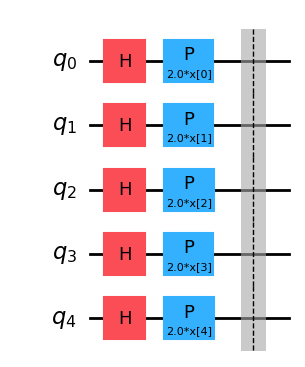

In [10]:
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap

num_features = df.shape[1]-1

#feature_map = PauliFeatureMap(feature_dimension=num_features, reps=1)
#feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map = ZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.barrier()
feature_map.decompose().draw(output="mpl", fold=20)

### Quantum Circuit Ansatz

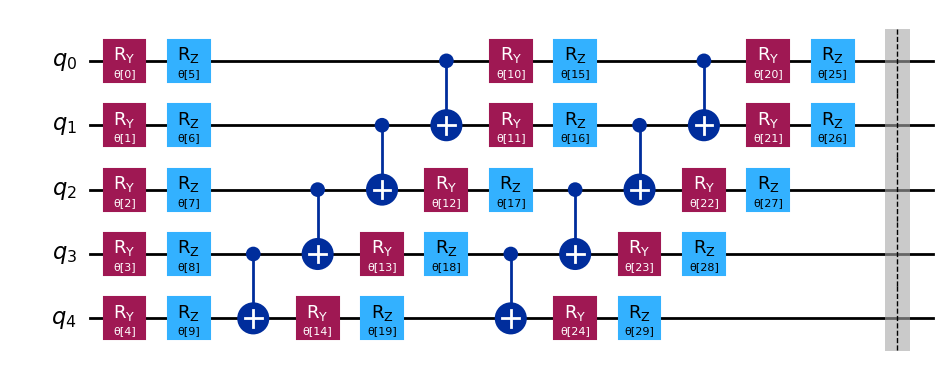

In [11]:
from qiskit.circuit.library import EfficientSU2, RealAmplitudes

ansatz=EfficientSU2(num_features,reps=2)
#ansatz=RealAmplitudes(num_features,reps=2)
ansatz.barrier()
ansatz.decompose().draw(output="mpl", fold=20)

## Combiniamo il tutto ed eseguiamo l'algoritmo Variational Quantum Classifier

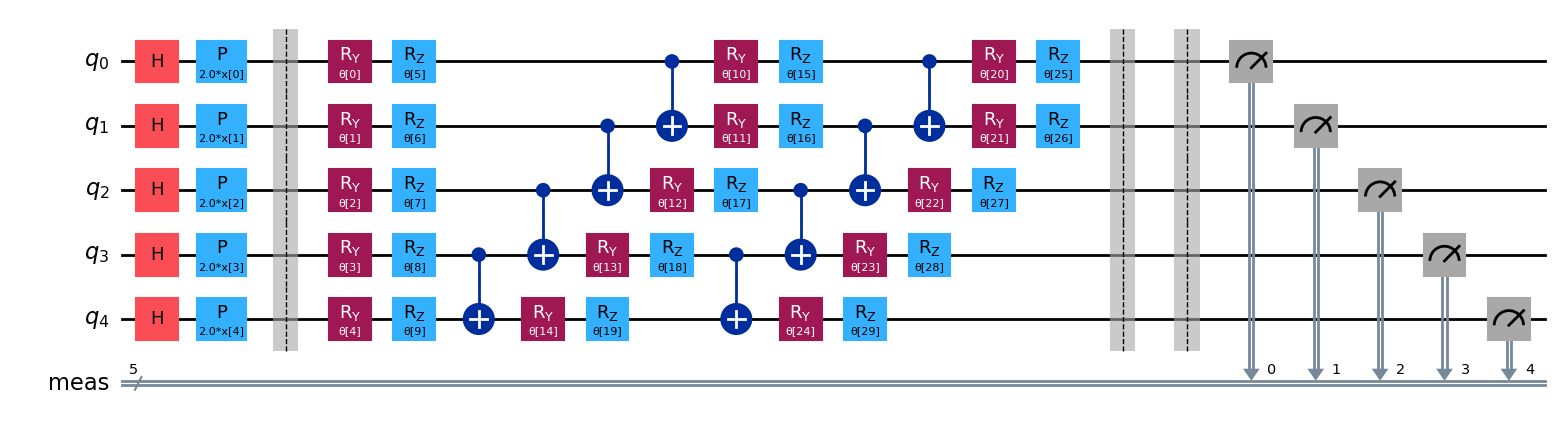

In [12]:
ad_hoc_circuit = feature_map.compose(ansatz)
ad_hoc_circuit.measure_all()
ad_hoc_circuit.decompose().draw(output="mpl", style="iqp")

### Funzioni di utilità per minimizzare la loss function

In [13]:
from matplotlib import pyplot as plt

In [14]:
def circuit_instance(tuple, variational):
    # tuple: una tupla
    # variational: parametri dell'ansatz (theta)
    parameters = {}
    for i, p in enumerate(feature_map.ordered_parameters):
        parameters[p] =tuple[i]
    for i, p in enumerate(ansatz.ordered_parameters):
        parameters[p] = variational[i]
    return ad_hoc_circuit.assign_parameters(parameters)


def interpreter(bitstring):
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight) % 2

def label_probability(results):
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    #probabilities = {0: 0, 1: 0, 2: 0}
    for bitstring, counts in results.items():
        label = interpreter(bitstring)
        probabilities[label] += counts / shots
    return probabilities

In [15]:
def classification_probability(data, variational):
    circuits = [circuit_instance(tupla, variational) for tupla in data]
    sampler = StatevectorSampler()
    results = sampler.run(circuits).result()
    classification = [label_probability(results[i].data.meas.get_counts()) for i, c in enumerate(circuits)]

    return classification


def classification_probability_with_noisy(data, variational):
    circuits = [circuit_instance(tupla, variational) for tupla in data]
    # Usa FakeVigo come backend simulato
    fake_backend = FakeVigoV2()
    sim = AerSimulator.from_backend(fake_backend)

    # Transpila il circuito per la topologia di FakeVigo
    transpiled_qc = transpile(circuits, sim)
    results = sim.run(transpiled_qc).result()

    classifications = []

    for result in results.get_counts():
        classifications.append(label_probability(result))

    return classifications



In [16]:
def cost_function(data, labels, variational):
    classifications = classification_probability(data, variational)
    cost=log_loss(y_true=labels,y_pred=[[p[0],p[1]] for p in classifications])
    return cost

def cost_function_with_noisy(data, labels, variational):
    classifications = classification_probability_with_noisy(data, variational)
    cost=log_loss(y_true=labels,y_pred=[[p[0],p[1]] for p in classifications])
    return cost

def objective_function(variational):
    #return cost_function_with_noisy(X_train_new,y_train_new,variational)
    return cost_function(X_train_new, y_train_new, variational)

In [17]:
from scipy.optimize import minimize, differential_evolution

class OptimizerLog:
    """Log per salvare i risultati intermedi dell'ottimizzazione."""
    def __init__(self):
        self.evaluations = 1
        self.parameters = []
        self.costs = []

    def callback(self, xk):
        """Funzione di callback compatibile con scipy.optimize.minimize."""
        cost = objective_function(xk)
        self.parameters.append(xk.copy())
        print("loss_function:", cost, "iterazione:", self.evaluations)
        self.costs.append(cost)
        self.evaluations += 1

# Istanzia il logger
logger = OptimizerLog()

# Punto iniziale (supponiamo che ansatz.num_parameters sia definito)
initial_point = np.zeros((ansatz.num_parameters))
#initial_point = np.random.uniform(0, 2*np.pi, size=ansatz.num_parameters)

#Esegui l'ottimizzazione
res = minimize(
    objective_function,
    initial_point,
    method="COBYLA",
    options={"maxiter": 5000, "disp": True},
    callback=logger.callback
)

loss_function: 0.6926251594479153 iterazione: 1
loss_function: 0.6925190245750391 iterazione: 2
loss_function: 0.6973206011054204 iterazione: 3
loss_function: 0.6960018968546229 iterazione: 4
loss_function: 0.9095309399491096 iterazione: 5
loss_function: 0.6956000253828727 iterazione: 6
loss_function: 0.6983422726367412 iterazione: 7
loss_function: 0.6936465964324918 iterazione: 8
loss_function: 0.6951487985724395 iterazione: 9
loss_function: 0.6881079320856855 iterazione: 10
loss_function: 0.6918712123501792 iterazione: 11
loss_function: 0.687184478083182 iterazione: 12
loss_function: 0.6954819705435594 iterazione: 13
loss_function: 0.690048317127578 iterazione: 14
loss_function: 1.0789082167524815 iterazione: 15
loss_function: 0.6897655137689523 iterazione: 16
loss_function: 0.6960309485067597 iterazione: 17
loss_function: 0.6942316304191859 iterazione: 18
loss_function: 0.6929850642208605 iterazione: 19
loss_function: 0.6956171575328225 iterazione: 20
loss_function: 0.67596474820346

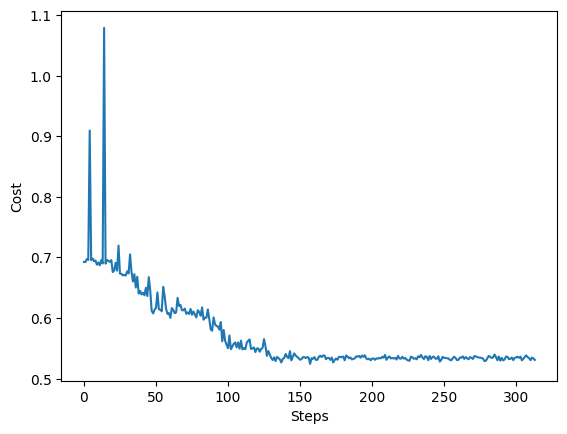

migliori parametri [ 1.56388117  0.34504496 -0.24633758  1.79147563 -1.14468587  0.60092567
 -0.47278429 -0.0672067   1.28213455 -0.75372321  0.43909335 -0.11210669
 -0.00456436  0.8910891   0.24268408 -0.43877422 -0.19780938 -0.4214258
  0.46024879  0.29042968  0.8637878   0.33328598  0.04296304 -0.21715538
 -0.97255176  1.24098782  0.0981319  -0.66568797  1.04688529 -0.18989483]
miglior funzione obiettivo 0.5348108404941552


In [18]:
opt_var = res.x # migliori parametri della funzione obiettivo e quindi dell'ansatz
opt_value = res.fun # ultima valutazione della funzione obiettivo, nel nostro caso cross-entropy (log_loss)

fig = plt.figure()
plt.plot(logger.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

print("migliori parametri",opt_var)
print("miglior funzione obiettivo",opt_value)

In [19]:
def test_classifier(data, labels, variational):
    probability = classification_probability_with_noisy(data, variational)
    #print(probability)
    predictions= [max(p, key=p.get) for p in probability]
    accuracy = 0
    for i, prediction in enumerate(predictions):
        if prediction == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, predictions

accuracy_train, predictions_train = test_classifier(X_train_new, y_train_new, opt_var)
accuracy_test, predictions_test = test_classifier(X_test_new, y_test_new, opt_var)
print(accuracy_train,accuracy_test)

0.7642857142857142 0.7666666666666667


In [20]:
accuracy_train=accuracy_score(y_train_new,predictions_train)
accuracy_test=accuracy_score(y_test_new,predictions_test)
print(accuracy_train)
print(accuracy_test)

0.7642857142857142
0.7666666666666667


In [21]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_new,predictions_test)

array([[23,  8],
       [ 6, 23]])

In [22]:
confusion_matrix(y_train_new,predictions_train)

array([[49, 20],
       [13, 58]])

### Risultati

In [23]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# Calcolo delle metriche
accuracy  = accuracy_score(y_test_new, predictions_test)
precision = precision_score(y_test_new, predictions_test)
recall    = recall_score(y_test_new, predictions_test)
f1        = f1_score(y_test_new, predictions_test)

print(f"Accuracy:  {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1-score:  {f1:.2f}")

Accuracy:  0.77
Precision: 0.74
Recall:    0.79
F1-score:  0.77
